<h1 style="property:value; background-color:skyblue;" align="center"> Data preparation and imputaion

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from data_preprocessor import *
from impute_utils import nrmse, evaluate, imputation

import warnings
warnings.filterwarnings('ignore')

### After gathering and preparing the data :
- Read the text files as csv.
- Concatinate all the data in one DataFrame.
- Resampling the whole data.
- Groupe the data by time and grid.
- Convevrt the full data into a numpy array, where each sample is a (100, 100) matrix.
 - Each matrix is the measurements for all grids at a spicific time step.
 - Each value in the matrix is a measurement for one grid at a this time step.
 
 
 Now we are going to deal with the final numpy data.

In [2]:
# Dealing with the data after gathering and resampling
path = r'C:\Users\Alaa Sedeeq\Downloads\Milan Data\Data'
full_data = np.load(r'{}\full_data.npy'.format(path), allow_pickle=True)
month_1 = np.load(r'{}\month_1.npy'.format(path), allow_pickle=True)
month_2 = np.load(r'{}\month_2.npy'.format(path), allow_pickle=True)

### Show some example of the data

#### Line plot for some grids over time.

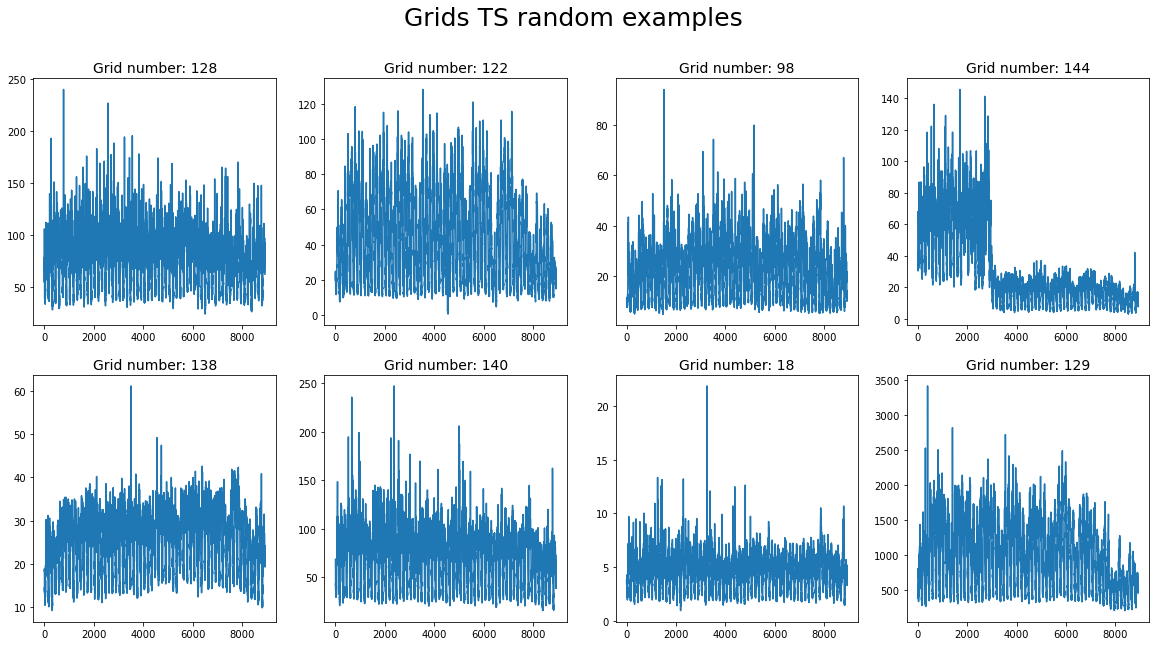

In [3]:
r, c = 2, 4
fig = plt.figure(figsize=(20,10))
fig.suptitle('Grids TS random examples', fontsize=25)

for i in range(r*c):
    x = np.random.randint(0, full_data.shape[1])
    y = np.random.randint(0, full_data.shape[2])
    plt.subplot(r, c, i+1)
    plt.title('Grid number: %d'%int(x+y), fontsize = 14)
    plt.plot(full_data[:,x,y,:]);

#### Full grids measurements at time steps.

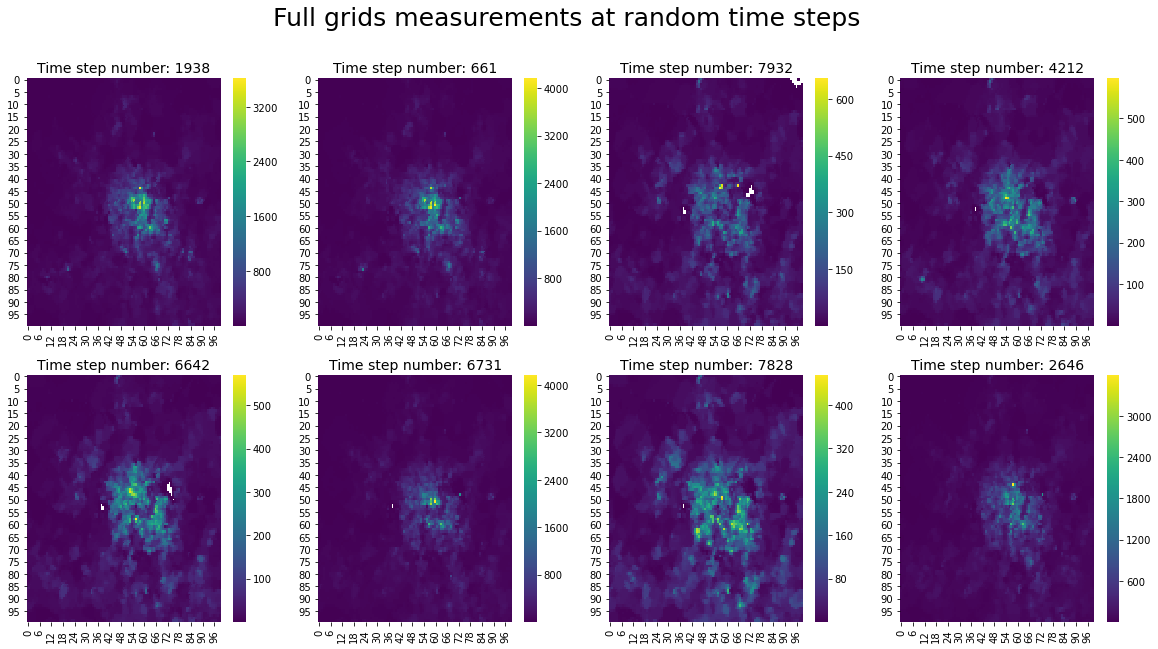

In [4]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Full grids measurements at random time steps', fontsize=25)

for i in range(r*c):
    s = np.random.randint(0, len(full_data))
    plt.subplot(r, c, i+1)
    plt.title('Time step number: %d'%s, fontsize = 14)
    sns.heatmap(full_data[s].reshape(100, 100), cmap='viridis')

#### NaN values in the data

In [5]:
nan_ratio_full = (np.isnan(full_data).sum()/len(full_data.flatten()))
print('NaN values ratio in the full data is : %f'%nan_ratio_full,'%')

NaN values ratio in the full data is : 0.000388 %


In [6]:
nan_ratio_1 = (np.isnan(month_1).sum()/len(full_data.flatten()))
print('NaN values ratio is : %f'%nan_ratio_1,'%')

NaN values ratio is : 0.000031 %


In [7]:
nan_ratio_2 = (np.isnan(month_2).sum()/len(full_data.flatten()))
print('NaN values ratio is : %f'%nan_ratio_2,'%')

NaN values ratio is : 0.000358 %


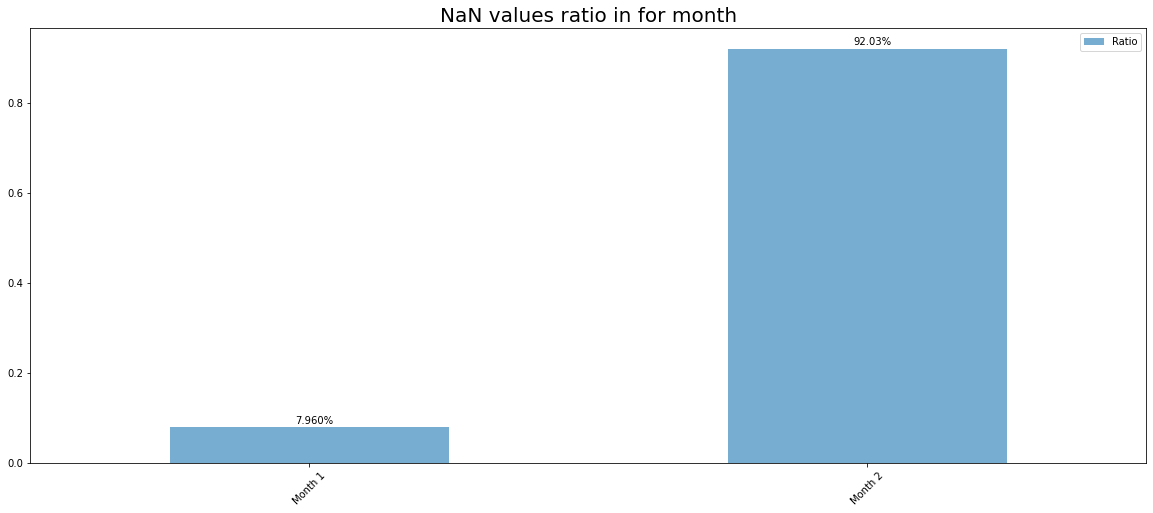

In [9]:
# create a dataframe of NaN ratios
nan_df = pd.DataFrame(data={'Month 1':nan_ratio_1/nan_ratio_full, 
                            'Month 2':nan_ratio_2/nan_ratio_full}, 
                      index=['Ratio']).T
# create a bar plot
ax = nan_df.plot(kind='bar', rot=45, alpha=0.6, figsize=(20, 8))
ax.set_title('NaN values ratio in for month', fontsize=20)
ax.annotate(str(str(ax.patches[0].get_height()*100)[:5]+'%'), (ax.patches[0].get_x()* 0.1, ax.patches[0].get_height()* 1.1))
ax.annotate(str(str(ax.patches[1].get_height()*100)[:5]+'%'), (ax.patches[1].get_x()* 1.3, ax.patches[1].get_height()* 1.01));

><b>Most of Null values in month 2. (92%), so we can work with month 1 to be able to evaluate our results.<br>
> I will work with the month one data and neglect this small ratio, then compare the performace of each imputation model with

#### Steps:
- Add synthesized NaN values with ratios (5%, 10%, 15%, 20%,
and 25%).
- Apply all methods for all grids with all of these ratios.
- Evaluate the performance of each method for all ratios using the NRMSE evaluation metrics.
- Compare different methods and decide which one to use.  

In [15]:
# We will deal with a reduced version of the data.
na_1 = np.isnan(month_1).sum()
# Use a new 40x40 grids instead of 100x100
na_2 = np.isnan(data_preprocessor(month_1, 40, 40)).sum()
print('NaN values in month 1: {}\nNan values in reduced version: {}'.format(na_1, na_2))

NaN values in month 1: 2761
Nan values in reduced version: 2069


><b>The (40 x 40) verson still has the most of nan value and also can be maintained easier by many algorithms to make comparison.

### Missing data imputation models
- We have several methods to impute time series data 
    - Conventional methods:
        - Ignore or deletion.
        - Mean imputation.
        - Mode imputation.
        - Median imputation.
    - Imputation procedure:
        - Last valid observation forward.
        - Next valid observation forward.
        - Interpolation.
    - Learnable methods:
        - KNN algorithm.
        - AutoRegressive.
        - Genitic algorithm.
        - MICE algorithm.
        - Least square SVM.
        - GAIN.
        - Conv-GAIN.
        
        
**But simply imputing the overall mean, median or mode to replace the NaN values is not a good idea with the complex seasonlaities.**

## Conventional methods

### 1) Mean

In [52]:
Mean_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Mean_Results.keys())

for ratio in bar:
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Mean_Results[ratio] = {ratio: value for ratio, value in imputation(data_x, miss_data_x, data_m, 'mean').items()}
    bar.set_description(f'{ratio} is Done!')

25% is Done!: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.62s/it]


In [53]:
Mean_Results = pd.DataFrame(Mean_Results).T
Mean_Results

,nrmse
5%,0.012987
10%,0.018340
15%,0.022455
20%,0.025930
25%,0.029015


### 2) Mode

In [54]:
Mode_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Mode_Results.keys())

for ratio in bar:
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Mode_Results[ratio] = {ratio: value for ratio, value in imputation(data_x, miss_data_x, data_m, 'mode').items()}
    bar.set_description(f'{ratio} is Done!')

25% is Done!: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.88s/it]


In [55]:
Mode_Results = pd.DataFrame(Mode_Results).T
Mode_Results

,nrmse
5%,0.021180
10%,0.030267
15%,0.037355
20%,0.043356
25%,0.049287


### 3) Median

In [56]:
Median_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Median_Results.keys())

for ratio in bar:
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Median_Results[ratio] = {ratio: value for ratio, value in imputation(data_x, miss_data_x, data_m, 'median').items()}
    bar.set_description(f'{ratio} is Done !')

25% is Done !: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.25s/it]


In [57]:
Median_Results = pd.DataFrame(Median_Results).T
Median_Results

,nrmse
5%,0.013289
10%,0.018804
15%,0.023003
20%,0.026623
25%,0.029764


#### Compare all imputaion conventional methods

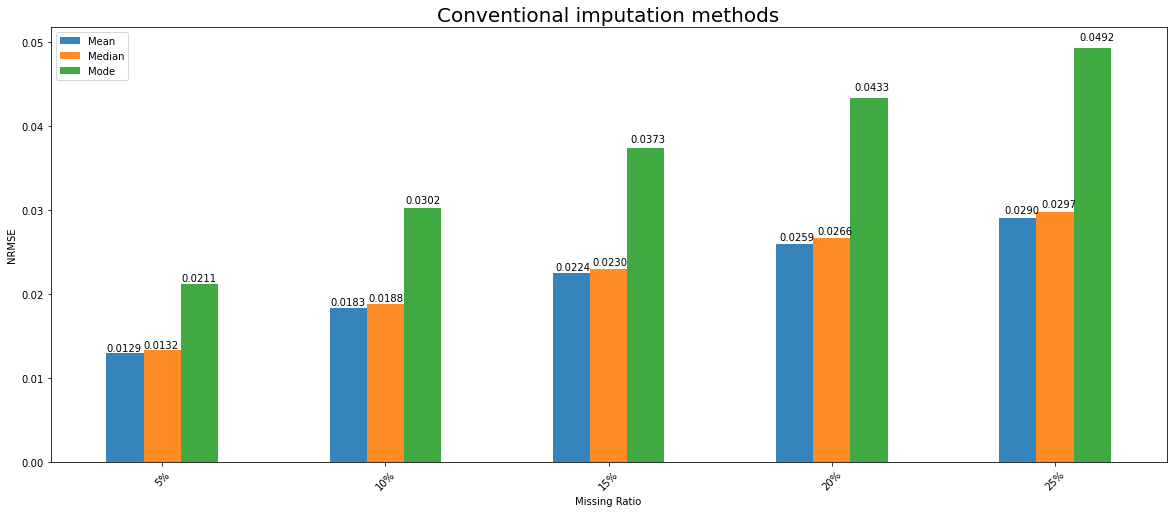

In [58]:
# Concatenate all results in one dataframe
full_conven_results = Mean_Results.rename(columns={'nrmse':'Mean'})
full_conven_results['Median'] = Median_Results
full_conven_results['Mode'] = Mode_Results

ax = full_conven_results.plot(kind='bar', rot=45, alpha=0.9, figsize=(20,8))
ax.set_title('Conventional imputation methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');
for p in ax.patches:
    ax.annotate(str(str(p.get_height())[:6]), (p.get_x()* 1.006, p.get_height()* 1.02))

## Imputaion procedure

### 1) Last valid observation

In [42]:
Lvo_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
Nvo_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Lvo_Results.keys())

for ratio in bar:        
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Lvo_Results[ratio] = imputation(data_x, miss_data_x, data_m, 'LVO')
    bar.set_description(f'{ratio} is Done !')

25% is Done !: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.41s/it]


In [43]:
Lvo_Results = pd.DataFrame(Lvo_Results).T
Lvo_Results

,nrmse
5%,0.004591
10%,0.006571
15%,0.008135
20%,0.009463
25%,0.010683


### 2) Next valid observation

In [44]:
Nvo_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Nvo_Results.keys())

for ratio in bar:        
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Nvo_Results[ratio] = imputation(data_x, miss_data_x, data_m, 'NVO')
    bar.set_description(f'{ratio} is Done !')

25% is Done !: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.12s/it]


In [45]:
Nvo_Results = pd.DataFrame(Nvo_Results).T
Nvo_Results

,nrmse
5%,0.004578
10%,0.006549
15%,0.008138
20%,0.009474
25%,0.010703


### 3) Interpolation

In [46]:
Interpolation_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Interpolation_Results.keys())

for ratio in bar:
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Interpolation_Results[ratio] = {ratio: value for ratio, value in \
                                    imputation(data_x, miss_data_x, data_m, 'inter').items()}
    bar.set_description(f'{ratio} is Done !')

25% is Done !: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [04:39<00:00, 55.92s/it]


In [47]:
Interpolation_Results = pd.DataFrame(Interpolation_Results).T
Interpolation_Results

,nrmse
5%,0.004849
10%,0.006978
15%,0.008662
20%,0.010175
25%,0.011578


#### Compare all imputaion procedure methods

In [49]:
# Concatenate all results in one dataframe
full_proc_results = Lvo_Results.rename(columns={'nrmse':'Last valid observation'})
full_proc_results['Next valid observation'] = Nvo_Results
full_proc_results['Interpolation'] = Interpolation_Results

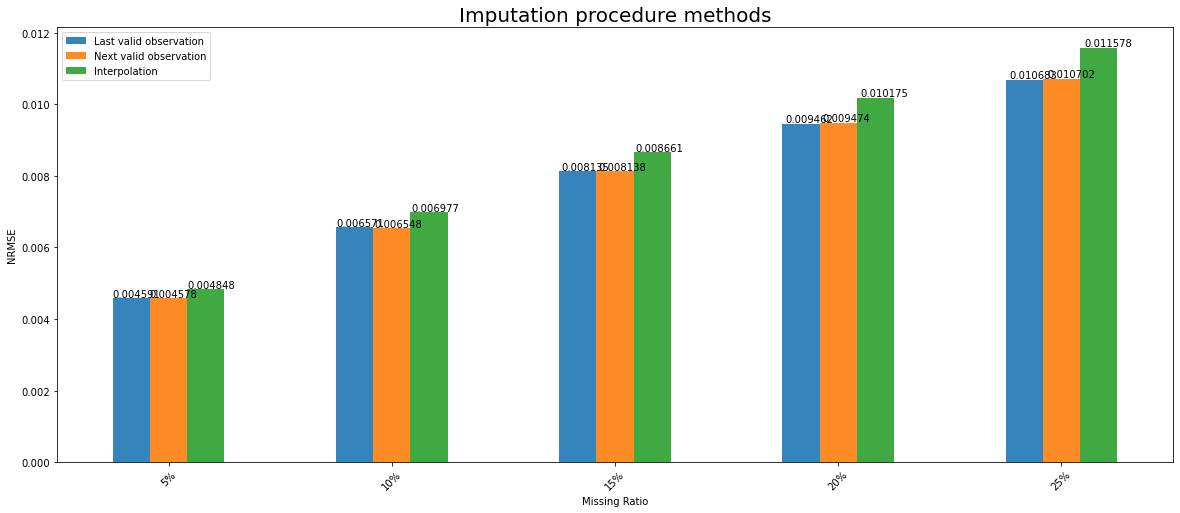

In [50]:
# Concatenate all results in one dataframe
ax = full_proc_results.plot(kind='bar', rot=45, alpha=0.9, figsize=(20,8));
ax.set_title('Imputation procedure methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');
for p in ax.patches:
    ax.annotate(str(str(p.get_height())[:8]), (p.get_x()* 1.005, p.get_height()* 1.005))

### Conventional vs. Procedure methods

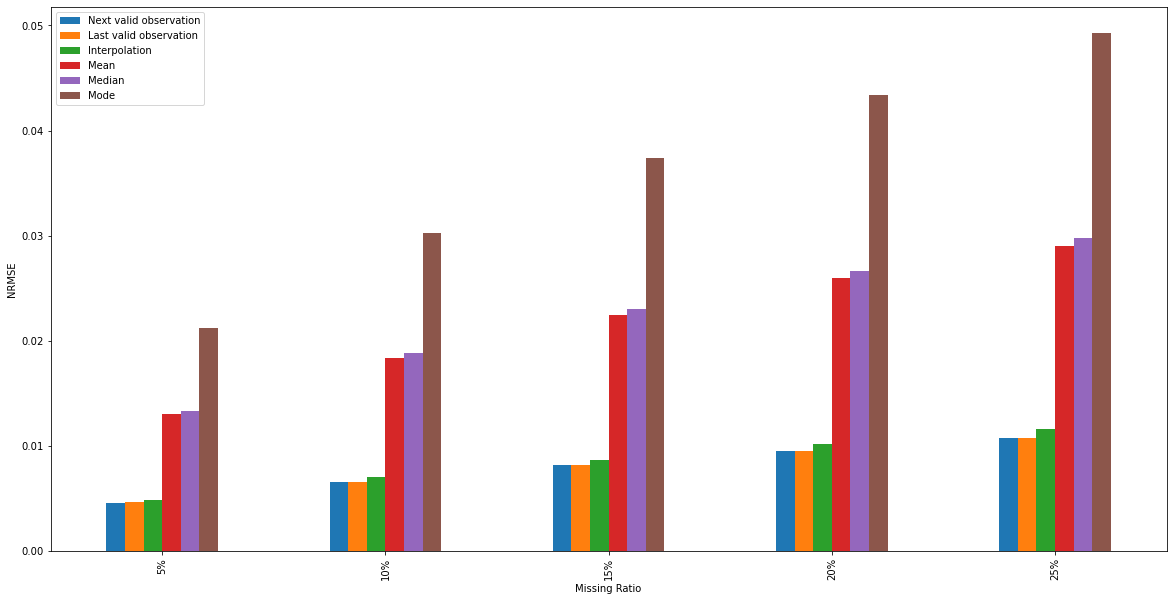

In [60]:
full_results = full_conven_results
full_results.to_csv('Con_Proc.csv')
full_results['Next valid observation'] = Nvo_Results
full_results['Last valid observation'] = Lvo_Results
full_results['Interpolation'] = Interpolation_Results
ax = full_results.T.sort_values('5%', ascending=True).T.plot(kind='bar', figsize=(20, 10), style='.-')
# for p in ax.patches:
#     ax.annotate(str(str(p.get_height())[:5]), (p.get_x()* 1.005, p.get_height()* 1.005))
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

## Learnable methods

### 1) MICE (Multiple imputation using chained equations)

<h3 align='center'>Example of MICE </h3><br>
<img src="images\MICE.png" height="800" width="800">

In [28]:
MICE_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

for ratio in MICE_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    MICE_Results[ratio] = imputation(data_x, miss_data_x, data_m, 'mice', max_iter=2)

In [29]:
MICE_Results = pd.DataFrame(index = MICE_Results.keys(), data = MICE_Results.values()).rename(columns={0:'MICE'})
MICE_Results

,MICE
5%,0.000286
10%,0.000401
15%,0.000491
20%,0.000566
25%,0.000633


### GAIN
<a href="https://arxiv.org/abs/1806.02920">Paper Link
<!-- <img src="images/D.png"></img> -->
<!-- <img src="images/G.png"></img> -->

In [10]:
from GAIN import GAIN
from gain_utils import *

Miss Ratio: 5%


Epoch(1): D_loss, G_loss ===> 0.200, 0.003: 100%|██████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Image : 3065
nrmse :  0.04061185064501781


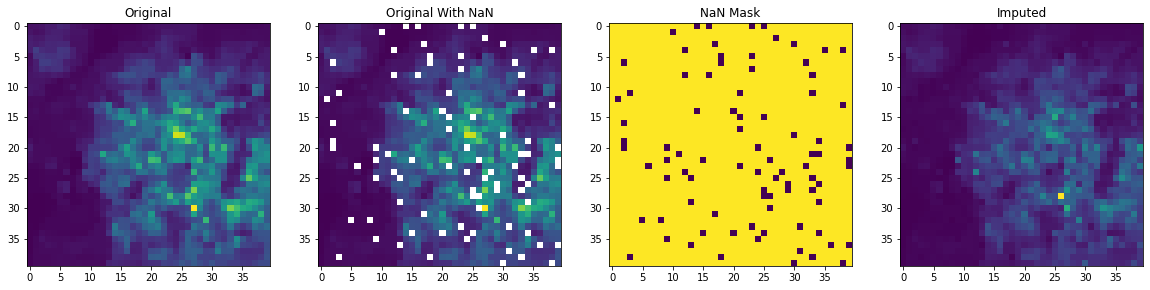

Image : 3614
nrmse :  0.01911016692459312


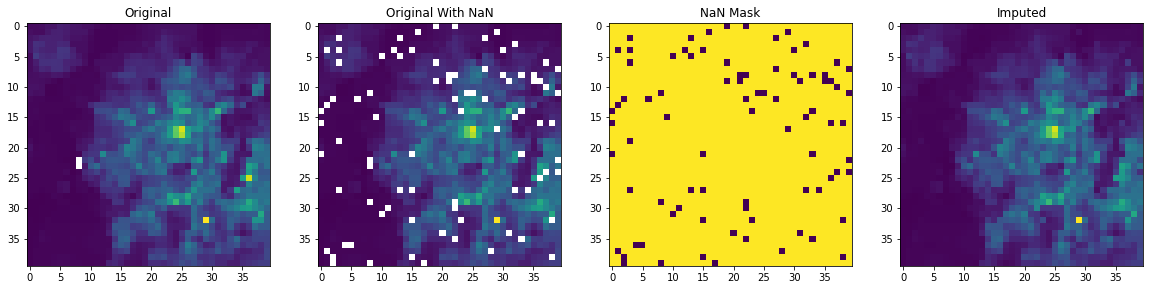

Miss Ratio: 10%


Epoch(1): D_loss, G_loss ===> 0.331, 0.011: 100%|██████████████████████████████████████| 67/67 [00:20<00:00,  3.24it/s]


Image : 3222
nrmse :  0.16809102113284377


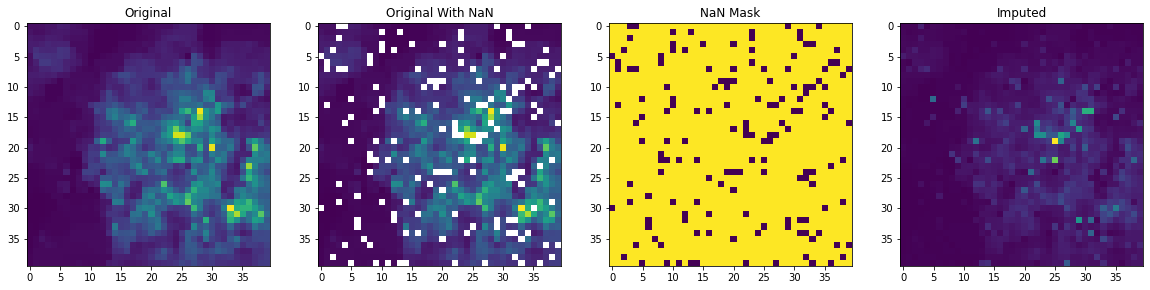

Image : 120
nrmse :  0.06936408951269687


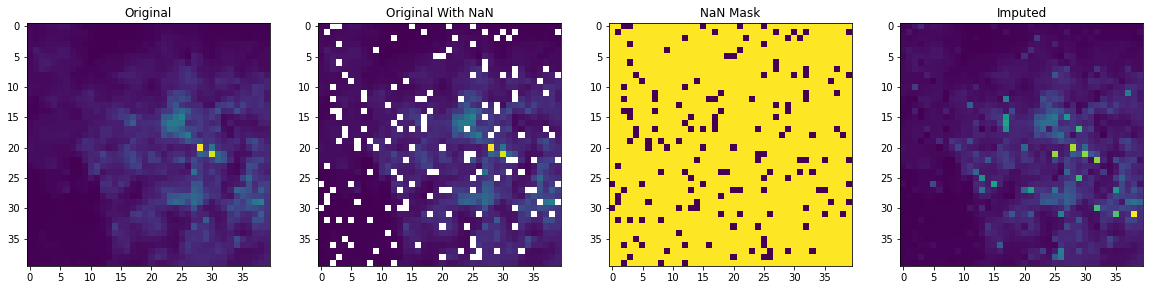

Miss Ratio: 15%


Epoch(1): D_loss, G_loss ===> 0.425, 0.026: 100%|██████████████████████████████████████| 67/67 [00:19<00:00,  3.39it/s]


Image : 759
nrmse :  0.4907323435473076


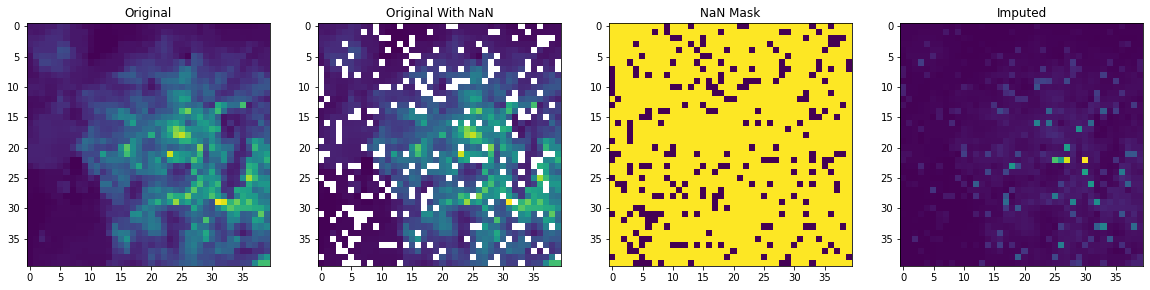

Image : 1796
nrmse :  0.04308547010385835


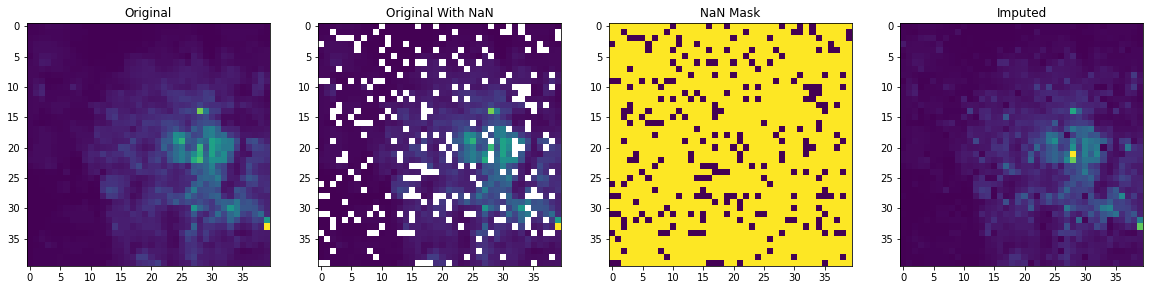

Miss Ratio: 20%


Epoch(1): D_loss, G_loss ===> 0.502, 0.044: 100%|██████████████████████████████████████| 67/67 [00:20<00:00,  3.24it/s]


Image : 3035
nrmse :  0.25304931611154663


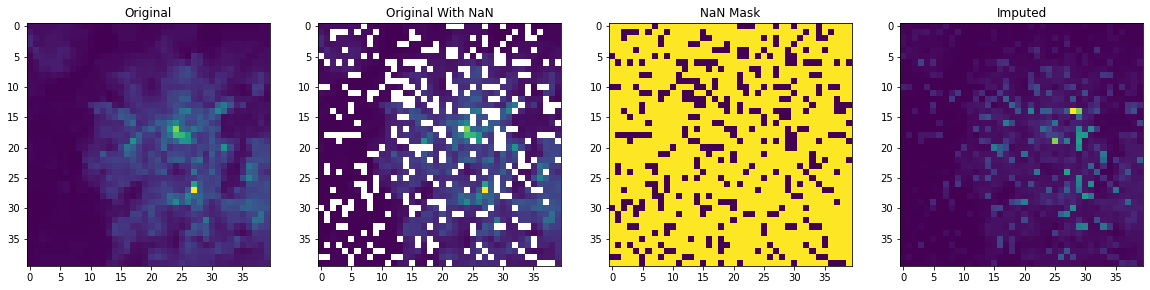

Image : 525
nrmse :  0.05994140600448084


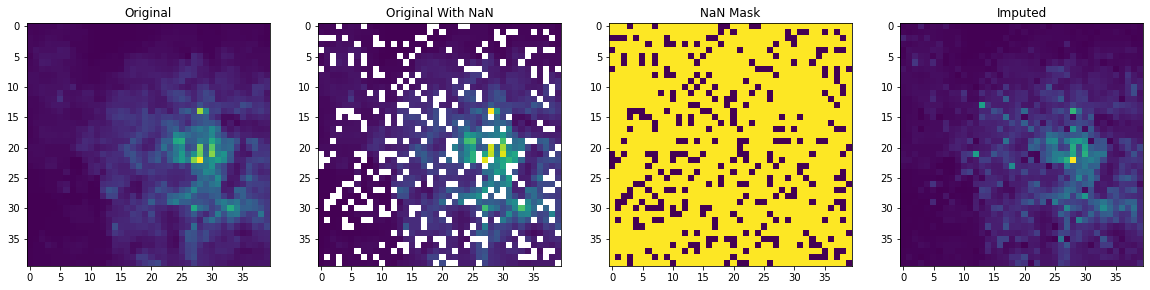

Miss Ratio: 25%


Epoch(1): D_loss, G_loss ===> 0.562, 0.079: 100%|██████████████████████████████████████| 67/67 [00:25<00:00,  2.68it/s]


Image : 126
nrmse :  0.2657682076391386


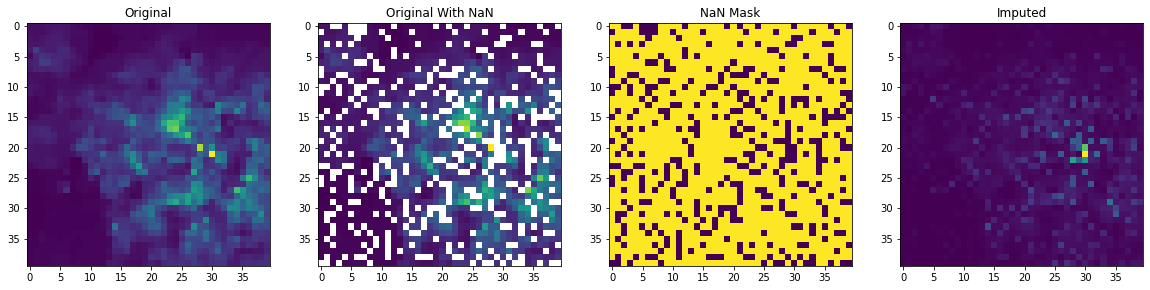

Image : 3303
nrmse :  0.17197064487791036


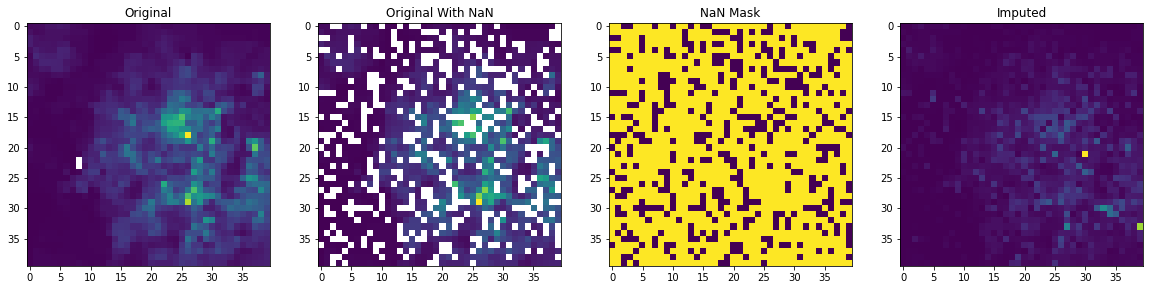

In [15]:
GAIN_Results ={'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

# apply the gain algorithms for all ratio and show two random samples after & before imputation
for ratio in GAIN_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(month_1, miss_rate, 40, 40)
    gain_parameters = {'batch_size':64,
                       'hint_rate':0.1,
                       'learning_rate':0.001,
                       'alpha':0.005,
                       'iterations':1}
    print('Miss Ratio: %s'%ratio)
    imputed_data = GAIN(miss_data_x, gain_parameters)
    show_results(data_x, miss_data_x, data_m, imputed_data, num_examples=2, cmap='viridis')
    GAIN_Results[ratio] = evaluate(actual=data_x, predicted=imputed_data, mask=data_m, metrics=(['nrmse']))

In [31]:
GAIN = pd.DataFrame(GAIN_Results).T.rename(columns={'nrmse':'GAIN'})
GAIN

,GAIN
5%,0.000008
10%,0.000056
15%,0.000056
20%,0.000061
25%,0.000060


### Conv-GAIN
- Performance is improved by applying convolutional neural networks instead of fully connected layers to better capture the correlation of data and promote learning from the adjacent surge points.<br>
- <a href="https://arxiv.org/abs/2111.02823">Paper Link</a><br>
- Here is my TensorFlow implementation

<h4 align="center">HandWritten Conv-GAIN architecture</h4>
<img src='images/Conv_Gain_HW.jpg' hight='1000', width='1000'></img><br>
<h4 align="center">The Proposed Conv-GAIN model</h4>
<img src="images/Conv_GAIN_Layers.jpg"></img>

In [18]:
from Conv_GAIN import Conv_GAIN
from conv_gain_utils import *

Miss Ratio: 5%


Epoch(1): D_loss, G_loss ===> 2.723, 0.109: 100%|██████████████████████████████████████| 67/67 [02:50<00:00,  2.55s/it]


Image : 4032
nrmse :  0.079583679329546


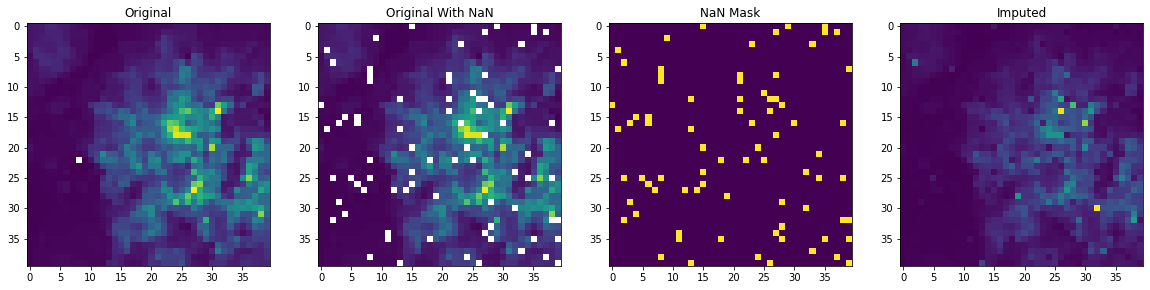

Image : 527
nrmse :  0.030012402996782782


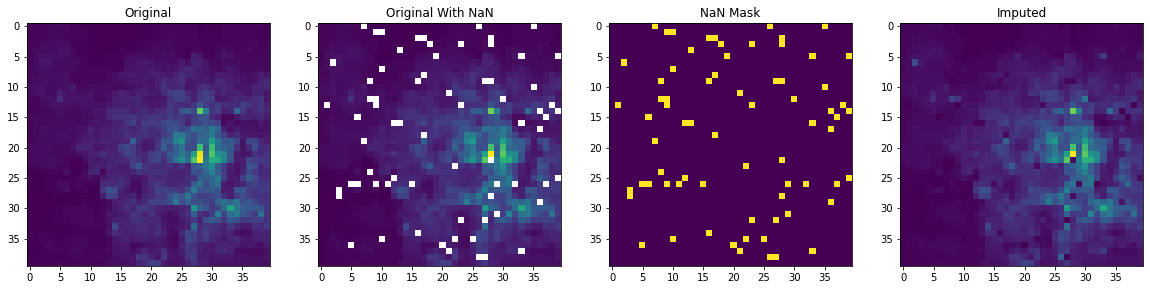

Miss Ratio: 10%


Epoch(1): D_loss, G_loss ===> 3.459, 0.198: 100%|██████████████████████████████████████| 67/67 [02:47<00:00,  2.50s/it]


Image : 29
nrmse :  0.22748691241309693


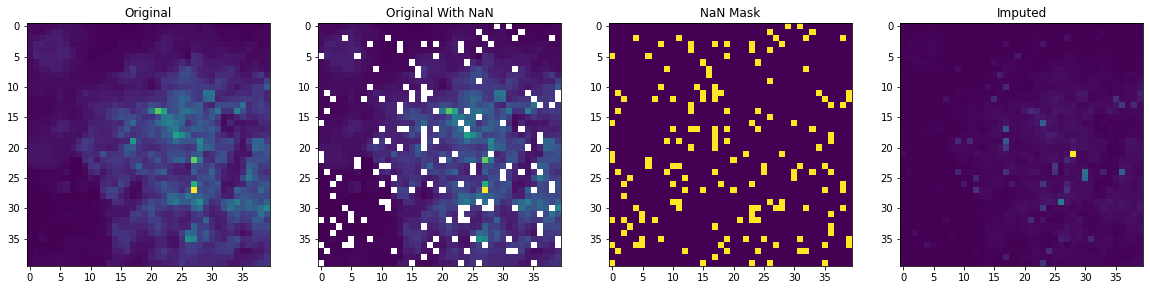

Image : 756
nrmse :  0.2532692995858651


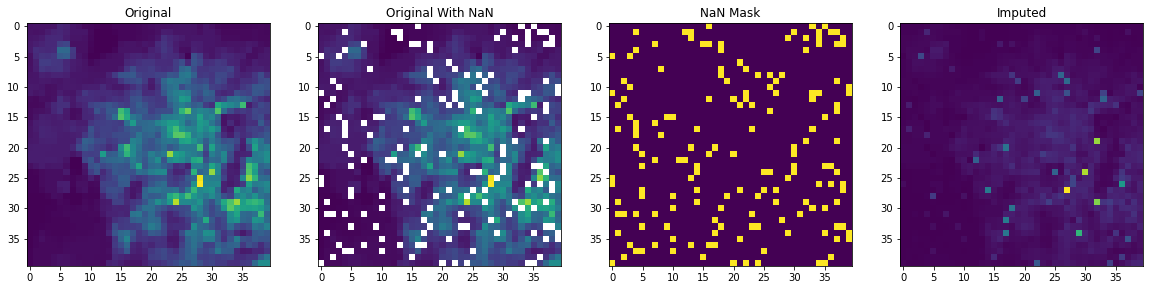

Miss Ratio: 15%


Epoch(1): D_loss, G_loss ===> 4.447, 0.352: 100%|██████████████████████████████████████| 67/67 [02:51<00:00,  2.56s/it]


Image : 4226
nrmse :  0.25437990821309775


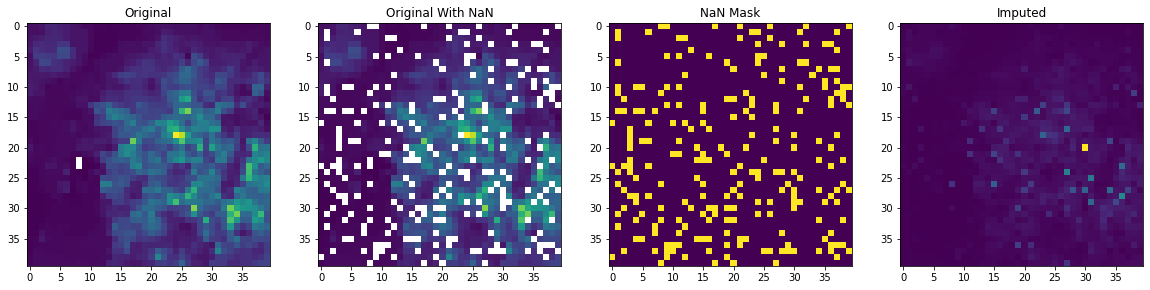

Image : 2588
nrmse :  0.17020692891884748


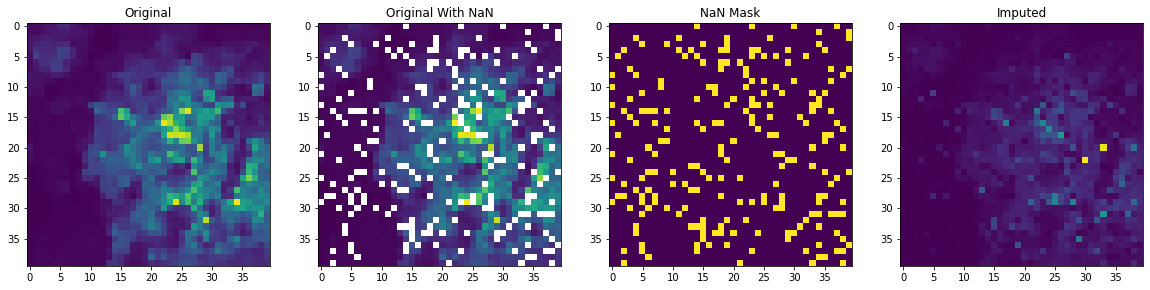

Miss Ratio: 20%


Epoch(1): D_loss, G_loss ===> 5.991, 0.768: 100%|██████████████████████████████████████| 67/67 [02:40<00:00,  2.40s/it]


Image : 4271
nrmse :  0.047135523744709105


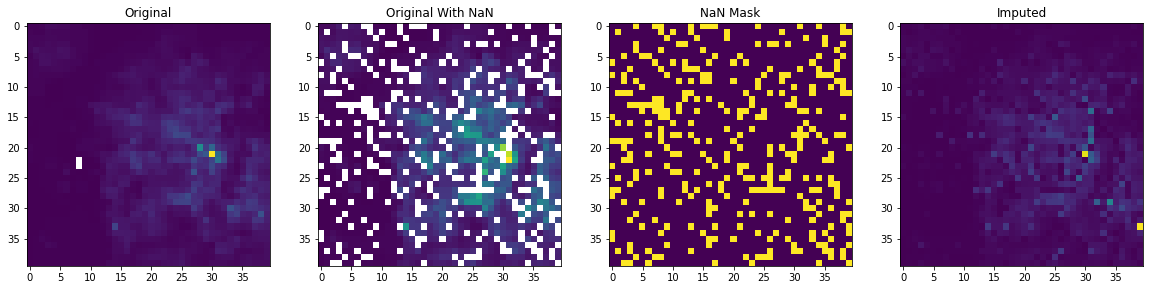

Image : 2492
nrmse :  0.3099575910178563


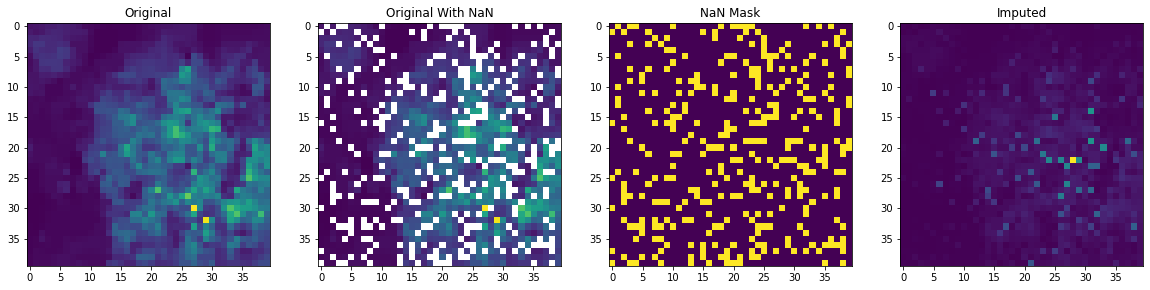

Miss Ratio: 25%


Epoch(1): D_loss, G_loss ===> 6.998, 1.193: 100%|██████████████████████████████████████| 67/67 [02:52<00:00,  2.58s/it]


Image : 3114
nrmse :  0.061399530632160026


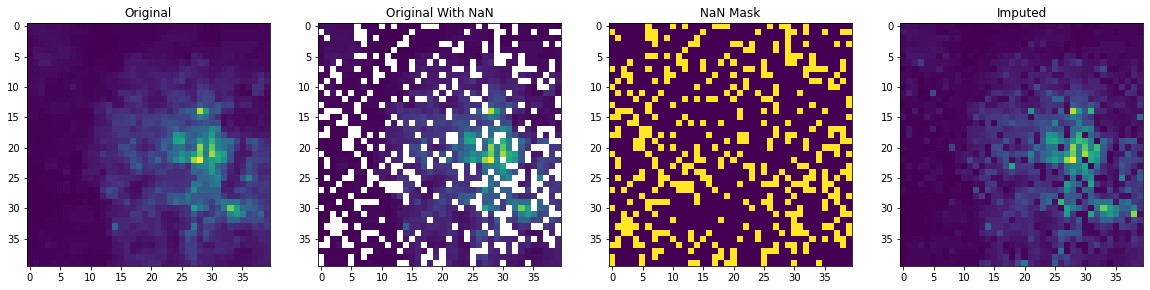

Image : 3452
nrmse :  0.1893127482353041


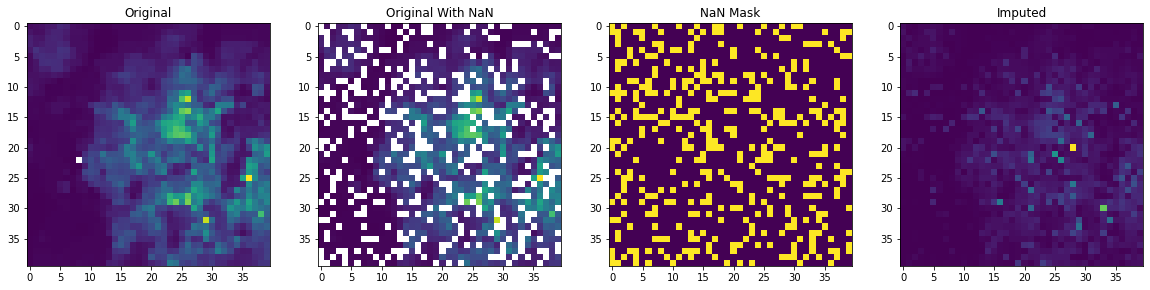

In [22]:
Conv_GAIN_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

# apply the gain algorithms for all ratio and show two random samples after & before imputation
for ratio in Conv_GAIN_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(month_1, miss_rate, 40, 40)
    conv_gain_parameters = {'batch_size':64,
                            'hint_rate':0.1,
                            'learning_rate':0.001,
                            'alpha':0.005,
                            'iterations':1}
    print('Miss Ratio: %s'%ratio)
    imputed_data = Conv_GAIN(miss_data_x, conv_gain_parameters)
    show_results(data_x, miss_data_x, data_m, imputed_data, num_examples=2, cmap='viridis')
    Conv_GAIN_Results[ratio] = evaluate(actual=data_x, predicted=imputed_data, mask=data_m, metrics=(['nrmse']))

In [32]:
Conv_Gain = pd.DataFrame(Conv_GAIN_Results).T.rename(columns={'nrmse':'Conv-GAIN'})
Conv_Gain

,Conv-GAIN
5%,0.000022
10%,0.000028
15%,0.000031
20%,0.000038
25%,0.000043


#### GAIN vs Conv-GAIN

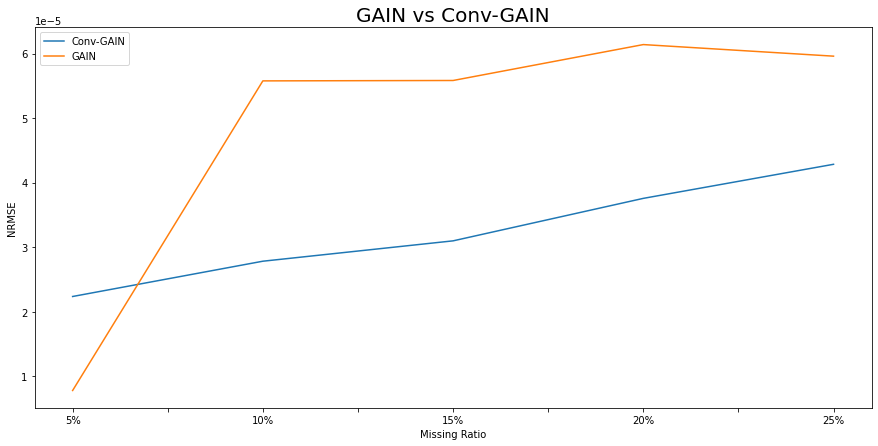

In [33]:
g_r = pd.DataFrame(Conv_GAIN_Results).T.rename(columns={'nrmse':'Conv-GAIN'})
g_r['GAIN'] = [list(GAIN_Results.values())[v]['nrmse'] for v in range(5)]
ax = g_r.plot(kind='line', figsize=(15, 7))
ax.set_title('GAIN vs Conv-GAIN', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

> ### We can see the performance improvement !

In [36]:
# Concatenate all results in one dataframe
full_learn_results = MICE_Results
full_learn_results['GAIN'] = GAIN
full_learn_results['Conv-GAIN'] = Conv_Gain
full_learn_results

,MICE,GAIN,Conv-GAIN
5%,0.000286,0.000008,0.000022
10%,0.000401,0.000056,0.000028
15%,0.000491,0.000056,0.000031
20%,0.000566,0.000061,0.000038
25%,0.000633,0.000060,0.000043


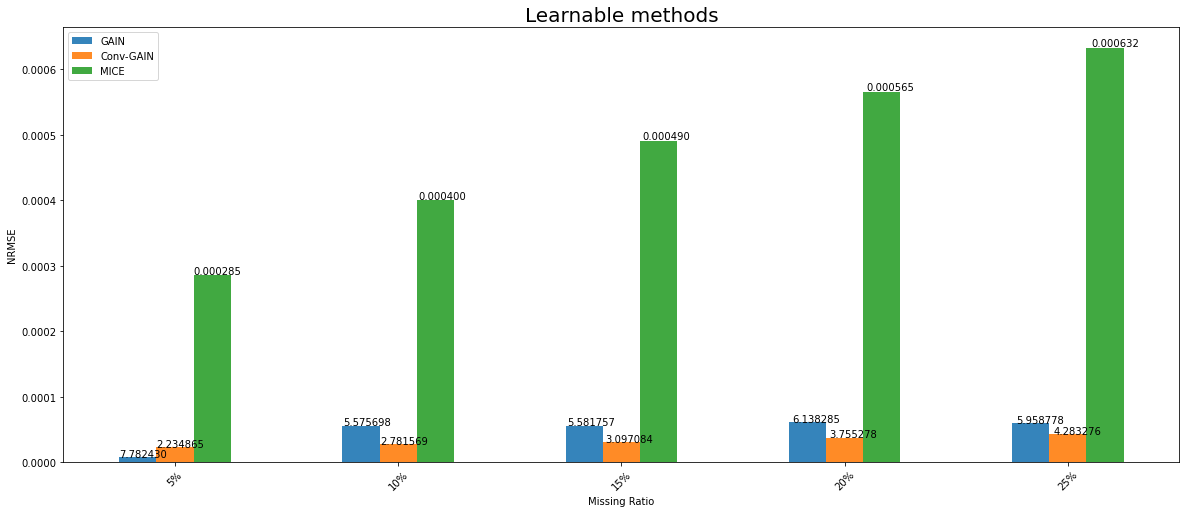

In [37]:
# Concatenate all results in one dataframe
ax = full_learn_results.T.sort_values(by='5%').T.plot(kind='bar', rot=45, alpha=0.9, figsize=(20,8));
ax.set_title('Learnable methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');
for p in ax.patches:
    ax.annotate(str(str(p.get_height())[:8]), (p.get_x()* 1.005, p.get_height()* 1.005))

##  All results

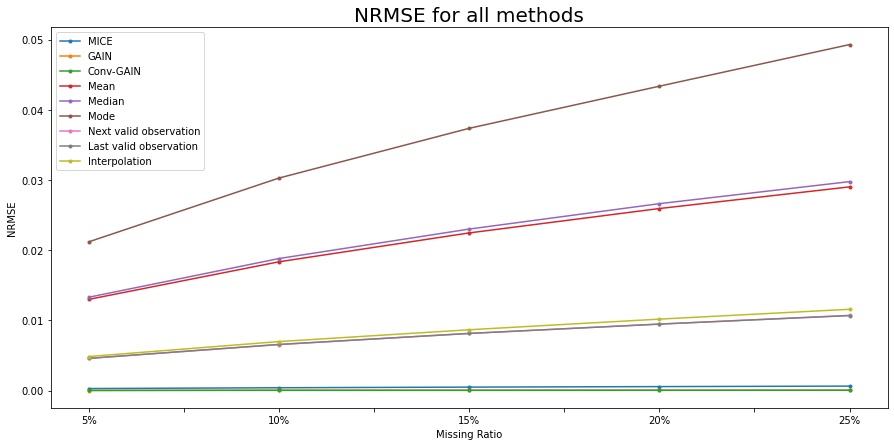

In [65]:
full_results = full_learn_results.join(full_results)
ax = full_results.plot(kind='line', figsize=(15, 7), style='.-')
ax.set_title('NRMSE for all methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

### Let's use Conv-GAIN Model to impute our data
- The shape of data is very large.
- We will apply the Conv-GAIN to the the data as a **sliding imputation window** with shape (25,25) slides over the whole data.

In [66]:
def full_data_imputaion(full_data:np.ndarray, square_length:int, conv_gain_parameters:dict):
    
    # check if the full data can be divided on squares each has the shape (square_length, square_length).
    if ((full_data.shape[1]%square_length) and (full_data.shape[2]%square_length)) != 0:
        raise(Exception('Expected a square length value so that full data can be divided into number of squares all have the same square length'))
    
    # create a new imputed data
    full_data_imputed = full_data.copy()

    # iterate over the all squares ===> 16 squares each square is (25, 25) (16*25*25=100*100=10000)
    for i in range(0, 4 ,1):
        for j in range(0, 4 ,1):
            print('Square : ({}, {})'.format(i, j))
            # get the imputed data
            temp = Conv_GAIN(full_data_imputed[:, i*square_length:i*square_length+square_length,\
                                               j*square_length:j*square_length+square_length],
                             conv_gain_parameters)
            # replace the origina data with the imputed data from the model 
            full_data_imputed[:,\
                              i*square_length:i*square_length+square_length,\
                              j*square_length:j*square_length+square_length] = temp
            
            # show an example from each model 
            idx = np.random.randint(1, len(full_data))
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.subplot(1,2,1).set_title('Original', fontsize=16)
            plt.imshow(full_data[idx, i*square_length:i*square_length+square_length,\
                                 j*square_length:j*square_length+square_length])
            plt.subplot(1,2,2)
            plt.subplot(1,2,2).set_title('Imputed', fontsize=16)
            plt.imshow(temp[idx]);
            plt.show()
            
    return full_data_imputed

Square : (0, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:06<00:00,  2.08it/s]


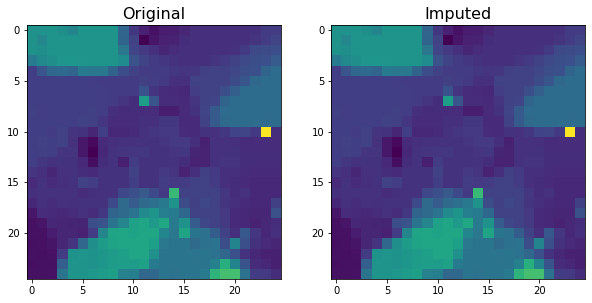

Square : (0, 1)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:04<00:00,  2.16it/s]


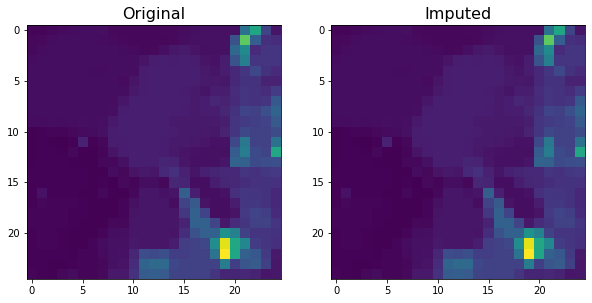

Square : (0, 2)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:13<00:00,  1.89it/s]


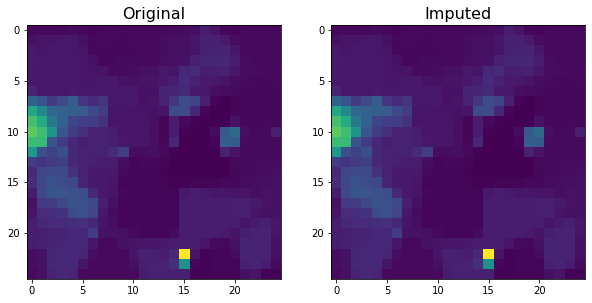

Square : (0, 3)


Epoch(1): D_loss, G_loss ===> 0.030, -0.000: 100%|███████████████████████████████████| 139/139 [01:08<00:00,  2.03it/s]


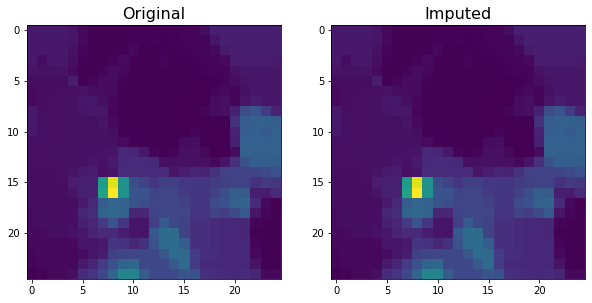

Square : (1, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|████████████████████████████████| 139/139 [1:11:36<00:00, 30.91s/it]


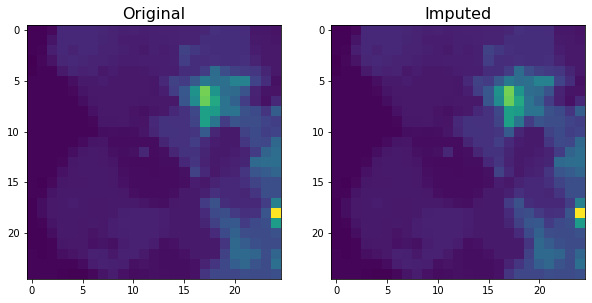

Square : (1, 1)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:15<00:00,  1.83it/s]


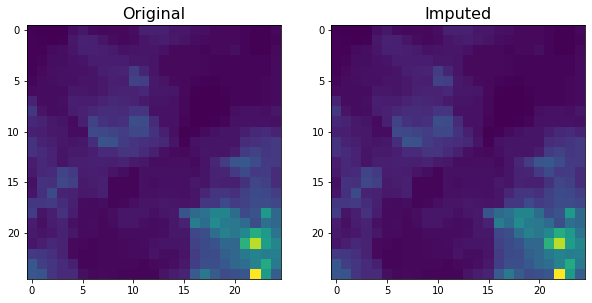

Square : (1, 2)


Epoch(1): D_loss, G_loss ===> 0.022, -0.000: 100%|███████████████████████████████████| 139/139 [01:19<00:00,  1.75it/s]


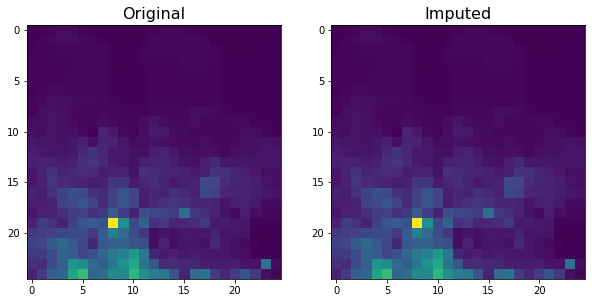

Square : (1, 3)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:29<00:00,  1.55it/s]


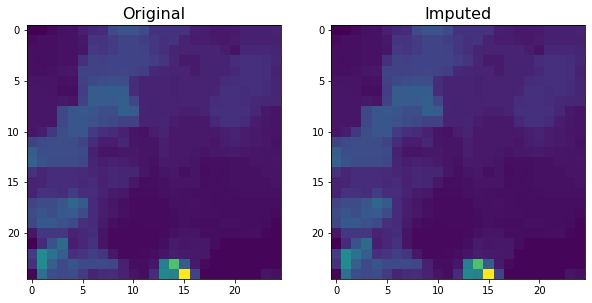

Square : (2, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:14<00:00,  1.87it/s]


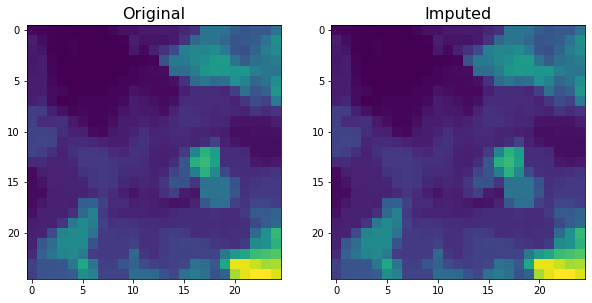

Square : (2, 1)


Epoch(1): D_loss, G_loss ===> 0.041, 0.035: 100%|████████████████████████████████████| 139/139 [01:16<00:00,  1.82it/s]


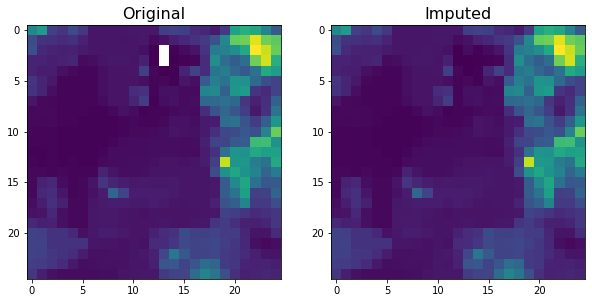

Square : (2, 2)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:16<00:00,  1.83it/s]


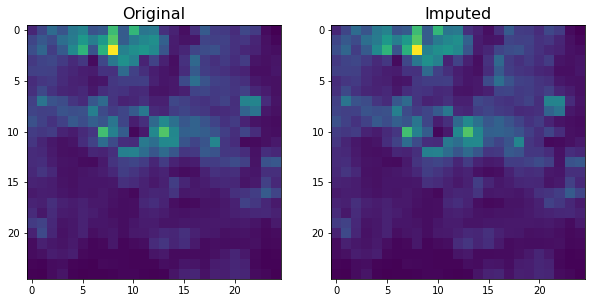

Square : (2, 3)


Epoch(1): D_loss, G_loss ===> 0.001, -0.000: 100%|███████████████████████████████████| 139/139 [01:16<00:00,  1.83it/s]


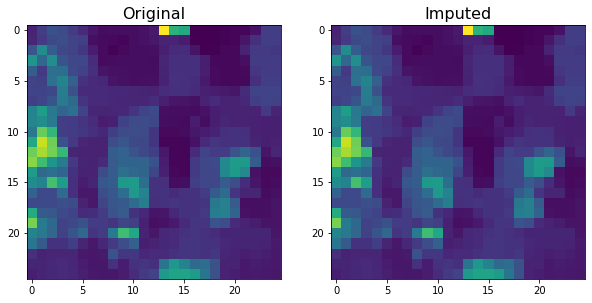

Square : (3, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:22<00:00,  1.69it/s]


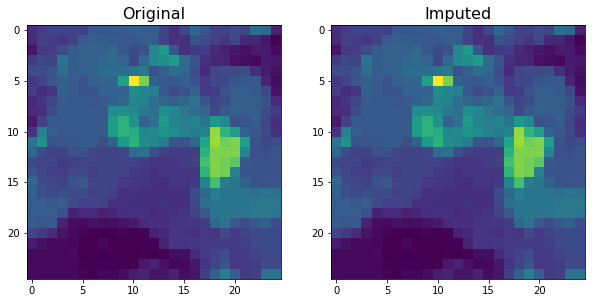

Square : (3, 1)


Epoch(1): D_loss, G_loss ===> 0.000, -0.000: 100%|███████████████████████████████████| 139/139 [01:19<00:00,  1.75it/s]


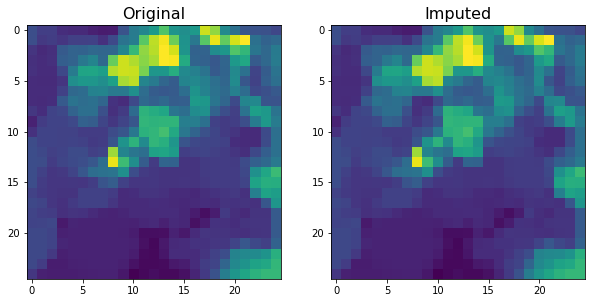

Square : (3, 2)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:16<00:00,  1.81it/s]


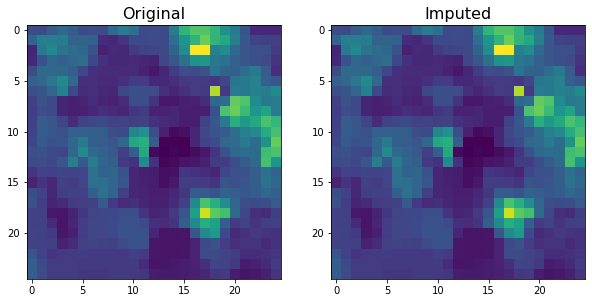

Square : (3, 3)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:15<00:00,  1.85it/s]


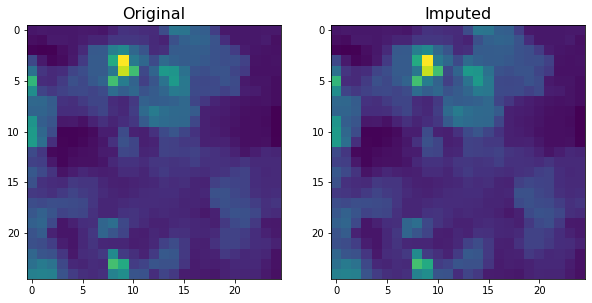

In [267]:
# define the model's hyperparameters
# impute the data by dividing it to 25x25 squares, and then impute each square separately.
conv_gain_parameters = {'batch_size':64,
                        'hint_rate':0.1,
                        'learning_rate':0.001,
                        'alpha':0.005,
                        'iterations':1}

full_data_imputed = full_data_imputaion(full_data=full_data, 
                                        square_length=25, 
                                        conv_gain_parameters=conv_gain_parameters)

### Let's use the full imputed data to create an animation

In [2]:
import numpy as np
path = r'C:\Users\Alaa Sedeeq\Downloads\Senior Project\Milan Data\Temp\Data'
full_grids_imputed = np.load(f'{path}/full_data_imputed.npy')

In [7]:
# Chck NaNs
print(f'Number of NaN values is : {np.isnan(full_grids_imputed).max()*1}')

Number of NaN values is : 0


In [9]:
full_grids_imputed.shape

(8928, 100, 100, 1)

### Let's Animate the traffic of all grids through all time steps

In [17]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt

# create plt figure
fig = plt.figure()
# extract all frames (one each time step)
frames = [full_grids_imputed[i,...] for i in range(full_grids_imputed.shape[0])]
ims = []

# append all frames in animated plt
for idx, frame in enumerate(frames):
    im = plt.imshow(frame, animated=True)
    ims.append([im]);

ani = animation.ArtistAnimation(fig, ims, interval=60, blit=True, repeat_delay=1000)

ani.save('images/animation.gif')

In [27]:
display(HTML('<img align="center" height="800" width="800" src="images/animated.gif">'))